## Convolution AutoEncoder

References:

* https://gist.github.com/tomokishii/7ddde510edb1c4273438ba0663b26fc6
* https://github.com/pkmital/tensorflow_tutorials
* https://github.com/chiphuyen/tf-stanford-tutorials
* https://blog.dominodatalab.com/imbalanced-datasets/
* https://pgaleone.eu/neural-networks/2016/11/24/convolutional-autoencoders/
* https://pgaleone.eu/neural-networks/deep-learning/2016/12/13/convolutional-autoencoders-in-tensorflow/
* https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/
* https://gist.github.com/Newmu/a56d5446416f5ad2bbac
* https://gist.github.com/kastnerkyle/f3f67424adda343fef40
* https://github.com/Kaixhin/Autoencoders
* https://github.com/siavashk/imagenet-autoencoder
* https://siavashk.github.io/2016/02/22/autoencoder-imagenet/
* http://torch.ch/blog/2015/11/13/gan.html
* https://github.com/andreaazzini/segnet
* https://github.com/tkuanlun350/Tensorflow-SegNet
* https://github.com/shekkizh/FCN.tensorflow
* http://techtalks.tv/talks/fully-convolutional-networks-for-semantic-segmentation/61606/
* https://github.com/xiaofanglegoc/tensorflow-fcn
* https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
* http://stackoverflow.com/questions/36548736/tensorflow-unpoolingtensorflow/tensorflow#2169
* https://arxiv.org/pdf/1412.7062.pdf
* https://arxiv.org/pdf/1511.07122.pdf
* https://hackernoon.com/autoencoders-deep-learning-bits-1-11731e200694

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


### Create some helper functions

In [3]:
# 2d Convolution
def conv2d(x, k_h, k_w, channels_in, channels_out, stride, act_type='relu', name="conv", viewWeights=False):
    with tf.name_scope(name):
        # Define weights
        w = tf.Variable(tf.truncated_normal([k_h,k_w, channels_in, channels_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        # Convolution
        #conv = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')    
        conv = tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding='SAME')    
                
        # Relu or sigmoid
        if act_type == 'relu':
            activation = tf.nn.relu(conv + b)
        else:
            activation = tf.sigmoid(conv + b)
        
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)
        
        # Visualize weights if needed
        if viewWeights == True:                        
            tf.summary.image("W_grid", put_kernels_on_grid(w,3,8), 1)            
            
        return activation

# 2d Transposed convolution (Deconvolution)
def conv2d_transpose(x, out_size, k_h, k_w, channels_in, channels_out, stride, act_type='relu', name="deconv"):
    with tf.name_scope(name):
        # Define weights (Notice that out/in channels are swapped on transposed conv)
        w = tf.Variable(tf.truncated_normal([k_h,k_w, channels_out, channels_in], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        
        # Image output shape
        shape4D = [tf.shape(x)[0], out_size[0], out_size[1], channels_out]
        # Deconvolution (Transposed convolution)
        conv = tf.nn.conv2d_transpose(x, w, output_shape=shape4D, strides=[1, stride, stride, 1], padding='SAME')                
        
        # Relu or sigmoid
        if act_type == 'relu':
            activation = tf.nn.relu(conv + b)
        else:
            activation = tf.sigmoid(conv + b)
        
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)                
            
        return activation    

def max_pool(x, k_h, k_w, S, name="maxpool"):
    with tf.name_scope(name):
        return tf.nn.max_pool(x, ksize=[1, k_h, k_w, 1],strides=[1, S, S, 1], padding='SAME')


def fc_layer(x, channels_in, channels_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([channels_in, channels_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        activation = tf.nn.relu(tf.matmul(x, w) + b)
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)
        return activation

Training...
  step, loss =      0:  0.615
  step, loss =   1000:  0.380
  step, loss =   2000:  0.362
  step, loss =   3000:  0.341
  step, loss =   4000:  0.246
  step, loss =   5000:  0.173
  step, loss =   6000:  0.149
  step, loss =   7000:  0.143
  step, loss =   8000:  0.126
  step, loss =   9000:  0.119
  step, loss =  10000:  0.121
loss (test) =  0.115633


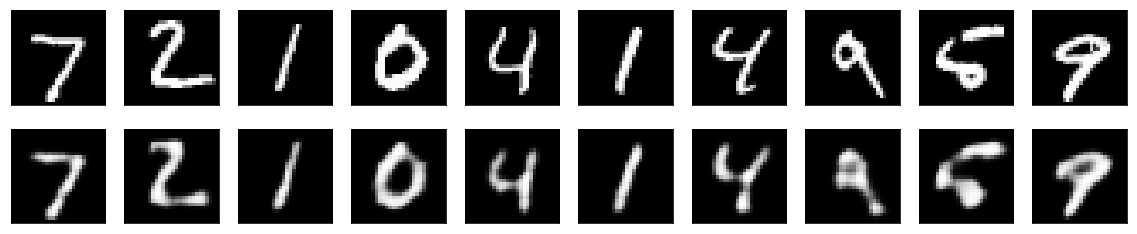

In [5]:
# Input placeholders
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10]) 

#loss, decoded = mk_nn_model(x, y_)
#######################################################
# Reshape to MNIST image dimensions 28x28x1
x_image = tf.reshape(x, [-1, 28, 28, 1])        
conv1_out = conv2d(x_image, 3, 3, 1, 16, 1, name="conv1")        
pool1_out = max_pool(conv1_out, 2, 2, 2, "pool1")        
conv2_out = conv2d(pool1_out, 14, 14, 16, 8, 1, name="conv2")        
pool2_out = max_pool(conv2_out, 2, 2, 2, "pool2")        
conv3_out = conv2d(pool2_out, 3, 3, 8, 8, 1, name="conv3")    
pool3_out = max_pool(conv3_out, 2, 2, 2, "pool3")

# at this point the representation is (8, 4, 4) i.e. 128-dimensional
# Decoding phase    
conv_t1_out = conv2d_transpose(pool3_out, (7, 7), 3, 3, 8, 8, 2,"dconv1")        
conv_t2_out = conv2d_transpose(conv_t1_out, (14, 14), 3, 3, 8, 8, 2,"dconv2")        
conv_t3_out = conv2d_transpose(conv_t2_out, (28, 28), 3, 3, 8, 16, 2,"dconv3")        

decoded = conv2d(conv_t3_out, 3, 3, 16, 1, 1,act_type='sigmoid',name="conv4")        

decoded = tf.reshape(decoded, [-1, 784])
cross_entropy = -1. *x *tf.log(decoded) - (1. - x) *tf.log(1. - decoded)
loss = tf.reduce_mean(cross_entropy)
#######################################################

train_step = tf.train.AdagradOptimizer(0.1).minimize(loss)

init = tf.global_variables_initializer()
# Train
with tf.Session() as sess:
    sess.run(init)
    print('Training...')
    for i in range(10001):
        batch_xs, batch_ys = mnist.train.next_batch(128)
        train_step.run({x: batch_xs, y_: batch_ys})
        if i % 1000 == 0:
            train_loss= loss.eval({x: batch_xs, y_: batch_ys})
            print('  step, loss = %6d: %6.3f' % (i, train_loss))

    # generate decoded image with test data
    test_fd = {x: mnist.test.images, y_: mnist.test.labels}
    decoded_imgs = decoded.eval(test_fd)
    print('loss (test) = ', loss.eval(test_fd))

x_test = mnist.test.images
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
#plt.savefig('mnist_ae2.png')